Libraries:

In [3]:
import warnings
warnings.filterwarnings('ignore')
import winsound
import math

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

from IPython.display import Image
from celluloid import Camera
from matplotlib.animation import PillowWriter
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from matplotlib.pyplot import figure
from tsfresh.utilities.dataframe_functions import impute
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from tsfresh import extract_features

import seaborn as sns
import matplotlib.patches as mpatches
from pylab import rcParams

from gluonts.model.deepar import DeepAREstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.seasonal_naive import SeasonalNaivePredictor
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator
from gluonts.trainer import Trainer
from itertools import islice

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import make_forecasting_frame

import statsmodels.formula.api as smf
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from tqdm import tqdm

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

Parameters:

In [4]:
predictions = 30
integration_order = 1
season_integration_order = 1 
season_period = 30

CDFs:

In [90]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotMovingAverage(series, window, center=True, plot_intervals=False, scale=1.96, plot_anomalies=False):

    rolling_mean = series.rolling(window=window).mean()
    error = mean_absolute_percentage_error(rolling_mean[window:].values, series[window:].values)
    
    plt.figure(figsize=(15,5))
    plt.title("Mean absolute percentage error {0:.0f}%".format(error))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    if plot_intervals:
        mae = mean_absolute_error(series[window:].fillna(0), rolling_mean[window:].fillna(0))
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=7)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method="ols")
        plt.tight_layout() 
        
def timeseries_train_test_split(X, y, test_size):
   
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test
    
def plotCoefficients(model):
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(8, 4))
    coefs.coef.plot(kind='bar')
    plt.title('Linear regression factors:')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')
    
def product(*args):
    if not args:
        return iter(((),)) 
    return (items + (item,) 
            for items in product(*args[:-1]) for item in args[-1])

def optimizeSARIMA(parameters_list, d, D, s):

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        try:
            model=sm.tsa.statespace.SARIMAX(df.y, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic

        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

def plotSARIMA(series, model, n_steps, s=24, d=1, plot_intervals=True, alpha=0.2):
    
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    data['arima_model'][:s+d] = np.NaN

    forecast = best_model.get_forecast(steps=50)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(8, 5))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")
    
    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'], 
                         y2=intervals['lower'], alpha=0.2, color = "grey")    
    
    
    plt.legend()
    plt.grid(True)
    
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):

    errors = []
    values = series.values
    alpha, beta, gamma = params
    
    tscv = TimeSeriesSplit(n_splits=3) 
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

class HoltWinters:
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
 
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))

        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])
            
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(15,5))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);
    
class LoopingPillowWriter(PillowWriter):
    def finish(self):
        self._frames[0].save(self._outfile, save_all=True, append_images=self._frames[1:],
                             duration=int(1000/self.fps), loop=0)
        
def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2, markersize=5)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()
        
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False):
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(8, 4))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=TimeSeriesSplit(), 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.0f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)  

Import data:

In [138]:
df = pd.read_excel('market/mbt.xlsx', sheet_name='First')
df['Date'] = pd.to_datetime(df['Date'])

print('Start:', str(df['Date'].iloc[1])[:10])
print('End:', str(df['Date'].iloc[-1])[:10])
print('Records:', len(df))

df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis = 1, inplace=True)
df.set_index(keys='Date', inplace=True)
df.columns = ['y']

df.head()

Start: 2005-04-12
End: 2020-04-09
Records: 3777


,y
Date,
2005-04-11,4.147989
2005-04-12,4.168266
2005-04-13,4.043219
2005-04-14,3.985765
2005-04-15,3.926056


Normalize returns:

In [159]:
df_res = ((df - df.shift(1))/df)**2
df_res.dropna(inplace=True)
df_res.head()

,y
Date,
2005-04-12,0.000024
2005-04-13,0.000957
2005-04-14,0.000208
2005-04-15,0.000231
2005-04-18,0.000909


ADF test for returns:

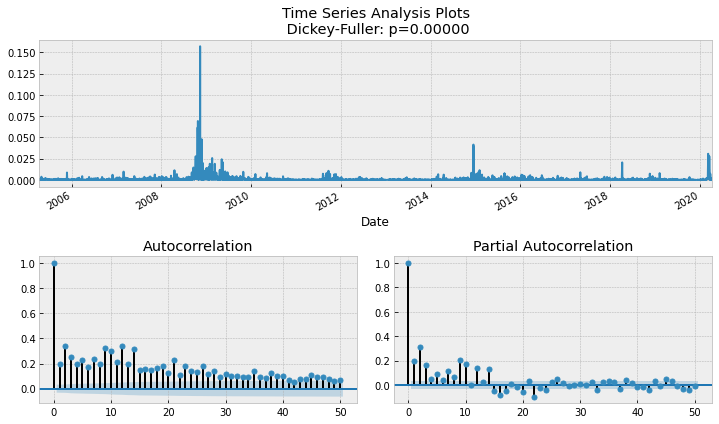

In [160]:
tsplot(df_res['y'], lags=50,  figsize=(10, 6))

p-value from scale:

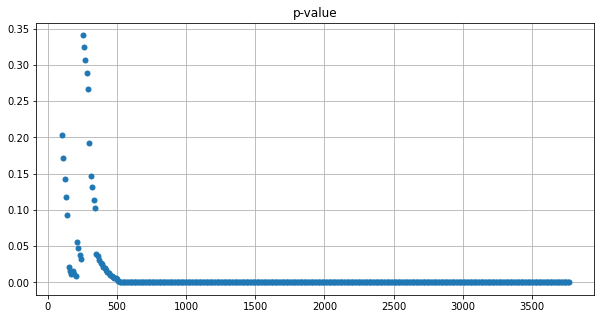

In [161]:
p_list, scale = [], []

for i in range(100, len(df_res), 10):
    p_value = sm.tsa.stattools.adfuller(df_res['y'].iloc[-i:])[1]
    p_list.append(p_value)
    scale.append(i)

plt.figure(figsize=(10,5))
plt.plot(scale, p_list, '.', markersize=10)
plt.title('p-value')
plt.grid()
plt.show()

Moving average for residuals:

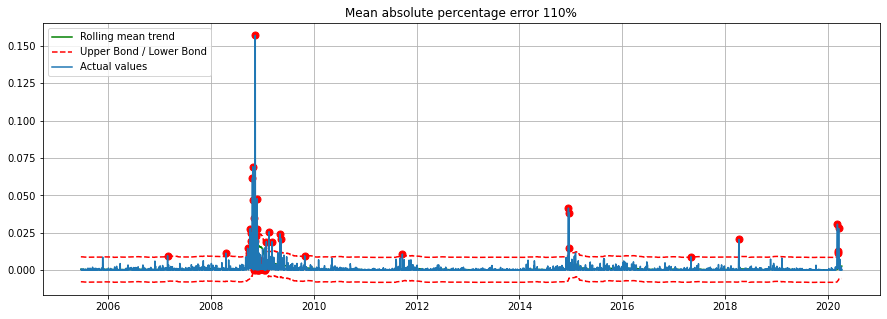

In [162]:
df_res.dropna(inplace=True)
plotMovingAverage(df_res, 50, plot_intervals=True, center=False, scale=2, plot_anomalies=True)

MAPE for normalized time series:

In [163]:
df_res['y'] = df_res['y'].apply(lambda x: (x - min(df_res['y'])))
df_res['y'] = df_res['y'].apply(lambda x: (x + 0.01*(max(df_res['y'])-min(df_res['y']))))
df_res['y+1'] =  df_res['y'].shift(1)
df_res.dropna(inplace=True)

error = mean_absolute_percentage_error(df_res['y'], df_res['y+1'])
print('Baseline MAPE:', int(error), '%')

Baseline MAPE: 37 %


Y vs Y+1:

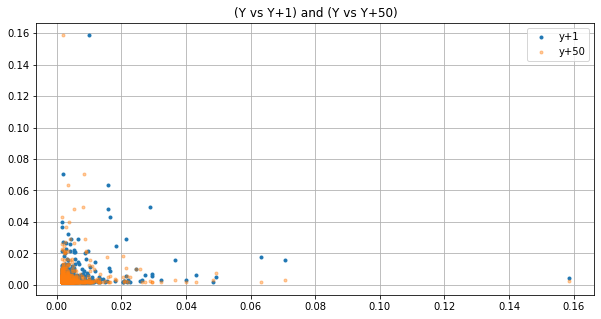

In [164]:
df_delta =  df_res.copy()
df_delta['y+1'] =  df_delta['y'].shift(1)
df_delta['y+50'] =  df_delta['y'].shift(50)

df_delta['y'] = df_delta['y'].apply(lambda x: (x - min(df_delta['y'])))
df_delta['y'] = df_delta['y'].apply(lambda x: (x + 0.01*(max(df_delta['y'])-min(df_delta['y']))))
df_delta.dropna(inplace=True)

plt.figure(figsize=(10,5))
plt.plot(df_delta['y'], df_delta['y+1'], '.')
plt.plot(df_delta['y'], df_delta['y+50'], '.', alpha=0.4)
plt.legend(['y+1','y+50'])

del df_res['y+1']

plt.title('(Y vs Y+1) and (Y vs Y+50)')
plt.grid()
plt.show()

Plot nomalized time series:

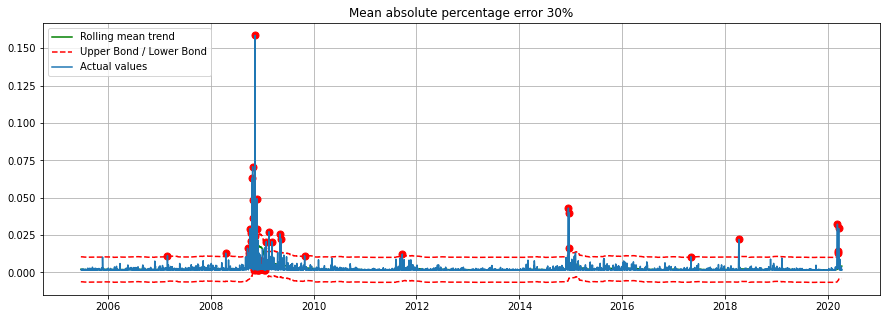

In [165]:
plotMovingAverage(df_res, 50, plot_intervals=True, center=False, scale=2, plot_anomalies=True)

Feature generation:

In [166]:
data = pd.DataFrame(df_res['y'].copy())
data.columns = ['y']

for i in range(1, 50):
    data["lag_{}".format(i)] = data.y.shift(i)

Correlation between features:

[]

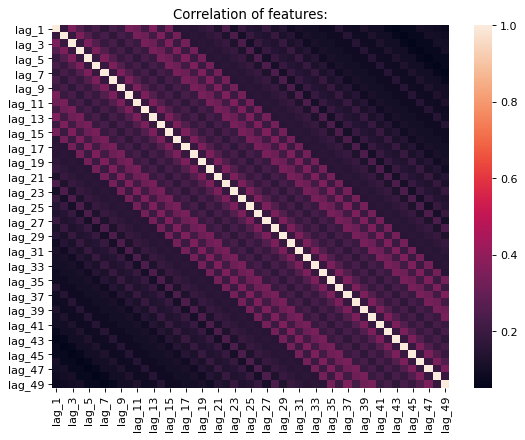

In [167]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(X_train.corr())
plt.title('Correlation of features:')
rcParams['figure.figsize'] = 5, 10
plt.plot()

Linear regression model:

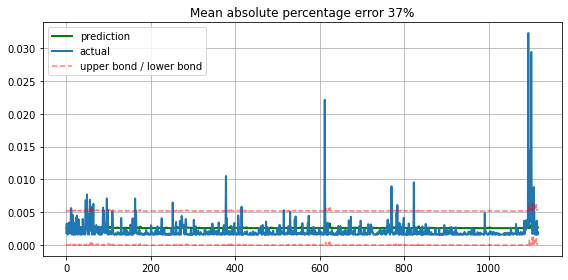

In [168]:
lasso = LassoCV(cv=TimeSeriesSplit(), eps = 0.01)
lasso.fit(X_train, y_train)
plotModelResults(lasso, X_train, X_test, plot_intervals=True, plot_anomalies=False)    

Linear regression model:

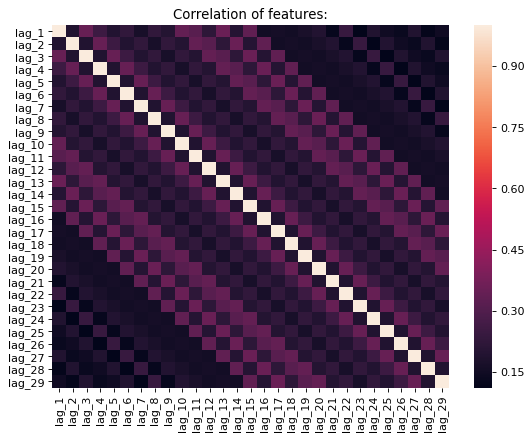

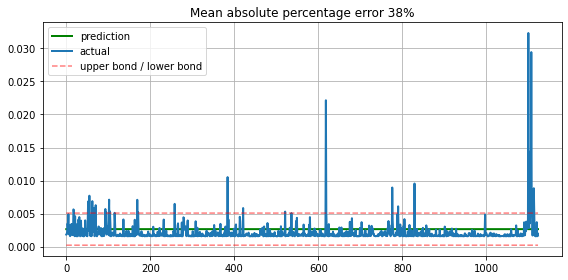

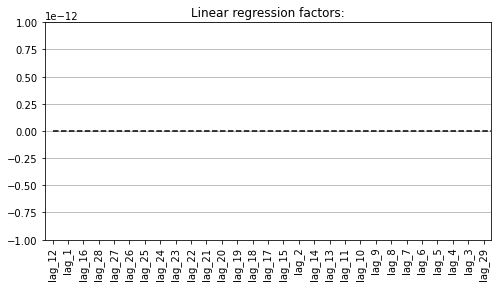

In [169]:
data = pd.DataFrame(df_res['y'].copy())
data.columns = ['y']

for i in range(1, 30):
    data["lag_{}".format(i)] = data.y.shift(i)

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(X_train.corr())
plt.title('Correlation of features:')
rcParams['figure.figsize'] = 5, 10
plt.plot()

lasso = LassoCV(cv=TimeSeriesSplit(), eps=0.01)
lasso.fit(X_train, y_train)
plotModelResults(lasso, X_train=X_train, X_test=X_test, plot_intervals=True, plot_anomalies=False)

plotCoefficients(lasso)

Gradient Boosting:

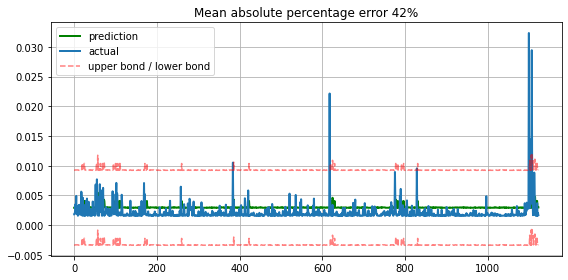

In [170]:
gbr = AdaBoostRegressor(n_estimators=10, loss='square')
gbr.fit(X_train, y_train)
plotModelResults(gbr, X_train=X_train, X_test=X_test, plot_intervals=True, plot_anomalies=False)

LSTM neural network - train data:

In [171]:
data = df_res.filter(['y'])
dataset = data.values
training_data_len = math.ceil(len(dataset) *.8)

scaler = MinMaxScaler(feature_range=(0,1)) 
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:training_data_len, : ]
x_train, y_train =[],[]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

Create model:

In [172]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
2960/2960 [==============================] - 208s 70ms/step - loss: 7.7959e-04


Prepare test data:

In [173]:
test_data = scaled_data[training_data_len - 60: , : ]

x_test = []
y_test =  dataset[training_data_len : , : ]

for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

Plot prediction vs actual:

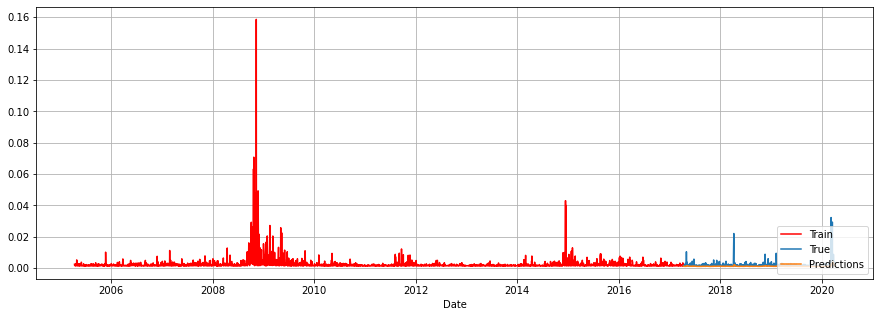

In [174]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(15,5))

plt.xlabel('Date')
plt.plot(train['y'], color='red')
plt.plot(valid[['y', 'Predictions']])

plt.legend(['Train', 'True', 'Predictions'], loc='lower right')
plt.grid()
plt.show()

MAPE:

In [175]:
print('MAPE:', int(mean_absolute_percentage_error(y_test, predictions)), '%')

MAPE: 31 %
